# Задание
1. Возьмите MNIST, обучите на нем сетку (LeNet)
2. Возьмите какую-нить картинку (из mnist’а)
3. Обучите шум, который при добавлении к оригинальной картинке, заставит ее ошибаться в пользу другого класса

In [17]:
import numpy as np
import torch
from torch import nn
import torchvision as tv
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [18]:
def load_mnist():
  train_dataset = datasets.MNIST('data', train=True, download=True,
                                 transform=transforms.Compose([
                                     transforms.Resize((32, 32)),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.1307,), (0.3081,))
                                 ]))
  
  test_dataset = datasets.MNIST('data', train=True, download=True,
                                 transform=transforms.Compose([
                                     transforms.Resize((32, 32)),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.1307), (0.3081,))
                                 ]))
  return train_dataset, test_dataset

In [19]:
def load_data(train_batch_size, test_batch_size):
    train_dataset, test_datset = load_mnist()
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = train_batch_size,shuffle=True)
    test_loader = torch.utils.data.DataLoader(train_dataset, batch_size = test_batch_size,shuffle=True)
    return (train_loader, test_loader)

##LeNet

In [20]:
class LeNet(nn.Module): 
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)      
        self.fc1 = nn.Linear(16 * 5 * 5, 120)          
        self.fc2 = nn.Linear(120, 84)         
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)   
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [21]:
def train_model(model, optimizer, epoch, train_loader, log_interval):
  model.train()
  loss_fn = torch.nn.CrossEntropyLoss()
  for batch_idx, (data, target) in enumerate(train_loader):
      optimizer.zero_grad()
      output = model(data)
      loss = loss_fn(output, target)
      loss.backward()
      optimizer.step()

In [22]:
def test_model(model, epoch, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  loss_fn = torch.nn.CrossEntropyLoss()
  for data, target in test_loader:
      data, target = Variable(data), Variable(target)
      output = model(data)
      test_loss = loss_fn(output, target)
      pred = np.argmax(output.data, axis=1)
      correct = correct + np.equal(pred, target.data).sum()
  test_loss /= len(test_loader.dataset)
  print(f'Test set, Epoch {epoch} , Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({ 100. * correct / len(test_loader.dataset):.0f}%)')

In [23]:
model = LeNet()
epochs = 5
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
train_batch_size = 1000
test_batch_size  = 1000
train_loader, test_loader = load_data(train_batch_size, test_batch_size)

for epoch in range(epochs):
    train_model(model, optimizer, epoch, train_loader, log_interval=100)
    test_model(model, epoch, test_loader)

Test set, Epoch 0 , Average loss: 0.0000, Accuracy: 55007/60000 (92%)
Test set, Epoch 1 , Average loss: 0.0000, Accuracy: 57172/60000 (95%)
Test set, Epoch 2 , Average loss: 0.0000, Accuracy: 57914/60000 (97%)
Test set, Epoch 3 , Average loss: 0.0000, Accuracy: 58413/60000 (97%)
Test set, Epoch 4 , Average loss: 0.0000, Accuracy: 58659/60000 (98%)


##Noise

In [24]:
class Noise(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.line = torch.nn.Linear(1024, 1024)
  def forward(self, input):
    x = self.line(input.flatten())
    x = x.view((32,32))
    return x

In [25]:
noise_m = torch.zeros((32, 32))
test_data = load_mnist()[0]

In [26]:
def check_attack(idx, n_iters = 10, step =2):
    model_noise = Noise()
    optim = torch.optim.Adam(model_noise.parameters(), lr = .1)
    crit  = torch.nn.CrossEntropyLoss()
    
    X = test_data[idx][0].unsqueeze(0).float() 
    X_in = X.squeeze().detach().cpu().numpy()
    y = torch.tensor(test_data[idx][1]).unsqueeze(0).type(torch.long)

    for iter in range(n_iters):
        model_noise.train()    
        optim.zero_grad()
        X_out = (X + model_noise(noise_m)).float() 
        pred  = model(X_out) 
        true_loss = crit(pred, y)
        loss = torch.exp(-true_loss) 
        loss.backward()
        optim.step()

        if iter in range(1, n_iters, step):
            X_out = X_out.squeeze().detach().cpu().numpy()
            fig, axs = plt.subplots(1, 3, figsize=(6,18))     
            axs[0].imshow(X_in)
            axs[1].imshow(X_out-X_in)
            axs[2].imshow(X_out)
            plt.title(f'{y[0].item()} -> {model(X + model_noise(noise_m))[0].argmax().item()}')
            plt.show()     
            print(model(X).argmax().item())                       
            print(f'iter {iter}, loss = {true_loss}')

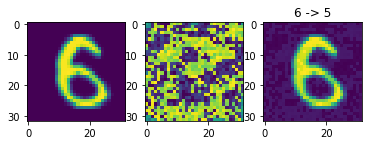

5
iter 1, loss = 4.869695663452148


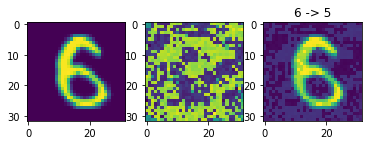

5
iter 3, loss = 8.571696281433105


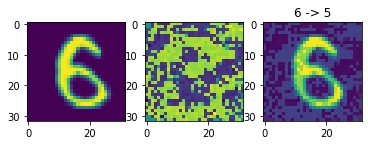

5
iter 5, loss = 11.056084632873535


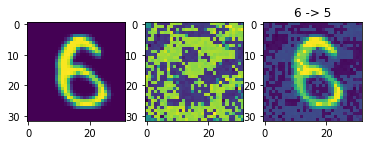

5
iter 7, loss = 12.911703109741211


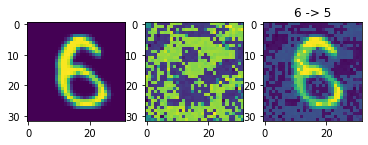

5
iter 9, loss = 14.32492733001709


In [27]:
check_attack(5632)